(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 4, 'status': 'small', 'time': 300, 'world': 3, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 175}


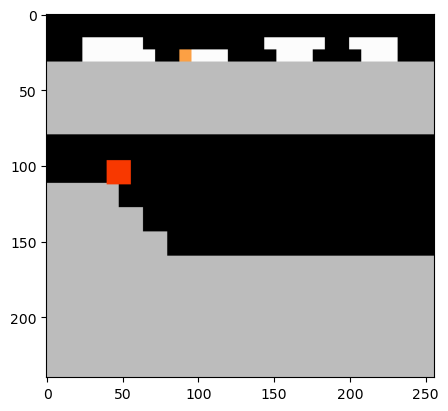

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque
import random, datetime, os, copy
import time
from pyvirtualdisplay import Display

# Gymは、Open AIのRL用ツールキット
import gym
from gym.spaces import Box  # 連続値の状態空間定義用
from gym.wrappers import FrameStack

# OpenAI Gym用に使うNES エミュレーター
from nes_py.wrappers import JoypadSpace
#OpenAI Gymのスーパー・マリオ・ブラザーズの環境
import gym_super_mario_bros

# stage 選択
stage = "3-4"
selected_env = "SuperMarioBros-" + stage + "-v3"
env = gym_super_mario_bros.make(selected_env)

from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# actions for very simple movement
# SIMPLE_MOVEMENT = [
#     ['NOOP'],
#     ['right'],
#     ['right', 'A'],
#     ['right', 'B'],
#     ['right', 'A', 'B'],
#     ['A'],
#     ['left'],
# ]
env = JoypadSpace(env, SIMPLE_MOVEMENT)

#再現性を保つためにseedを固定
seed = 15
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.action_space.seed(seed)

# 表示テスト
env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}") # f文字列（フォーマット文字列）
    # [3,240, 256]という配列はそれぞれ、画面の[チャネル数, 高さ、幅]
plt.figure(figsize=(5,5))
plt.axis=('off')
plt.imshow(next_state)

In [3]:
# ラッパーはエージェントにデータを渡す前にデータを前処理


# 状態データサイズ縮小 
# この処理をすると、状態サイズ[1, 240, 256]

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]  # =(240,256)
        self.observation_space=Box(low=0,high=255,shape=obs_shape,dtype=np.uint8) #状態空間定義

    def permute_orientation(self, observation):
        # [H, W, C] arrayを[C, H, W] tensorに変換
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

# 各observationを正方形の画像にダウンサンプリング
# この処理を適用すると、状態のサイズは[1, 84, 84]

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):    # shapeがintならTrue
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:] # カラーチャンネルがあったら付け加える．タプルの'+'は結合．
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0) # GrayScale入力ならsqueeze(0)で次元を減らしている．
        return observation
  
# https://github.com/zakopuro/RL_mario

# CustomRewardAndDoneラッパー
class CustomRewardAndDoneEnv(gym.Wrapper):
    # 初期化
    def __init__(self, env, skip):
        super(CustomRewardAndDoneEnv, self).__init__(env)
        self._skip = skip
        self._cur_x = 0.0
        self._max_x = 0.0

    # リセット
    def reset(self, **kwargs):
        self._cur_x = 0.0
        return self.env.reset(**kwargs)

    # ステップ
    def step(self, action):
        total_reward = 0.0
        done = False
        
        for i in range(self._skip):
            # 各フレームごとの報酬はn番目のフレームに集約
            # 報酬を蓄積し、同じ行動を繰り返す
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        
        # 報酬の変更
        if info['flag_get']:
            print("GOAL")
            total_reward += 100
            
        if info['x_pos'] >= self._max_x:
            self._max_x = info['x_pos']
            total_reward += 10
            
        if (info['x_pos'] < self._max_x) & (info['x_pos'] - self._max_x > -100):
            total_reward += 5
                
        if info['x_pos'] > self._cur_x:
            total_reward += 10

        elif info['x_pos'] == self._cur_x:
            total_reward -= 2
            
        else:
            total_reward -= 4

        self._cur_x = info['x_pos']

        total_reward -= 30 * (info['life'] - 1) # if info['life'] < 1:  total_reward -= 30

        if info['life'] == 1:
            done = True
            
        total_reward *= 0.2

        return state, total_reward, done, info

# Wrapper
# 4つの連続したグレースケールのフレームを重ね合わせたものになる
# マリオが行動を取るたびに環境は状態を返す
# サイズ[4, 84, 84]の3次元配列

#-----------------------------------------------------
#-----------------------------------------------------


# マリオは経験を一時的に記憶

class Mario:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        # 最適な行動を予測するマリオ用のDNN
        self.net = MarioNet(self.state_dim, self.action_dim).float()

    def act(self, state):
        """
        ε-greedy法で行動を選択

        Inputs:
            state(LazyFrame):現在の状態における一つの観測オブジェクト(state_dim)次元
        Outputs:
            action_idx (int): 整数値
        """
        # 探索（EXPLORE）
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # 活用（EXPLOIT）
        else:
            state = state.__array__()  # ndarray.__array__() コピー作成
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online") # actionを選ぶ
            action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rate減衰
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # ステップ+1
        self.curr_step += 1
        return action_idx

#-----------------------------------

class Mario(Mario):
    
    def cache(self, state, next_state, action, reward, done):
        """
        経験をself.memory (replay buffer)に保存

        Inputs:
            state (LazyFrame),
            next_state (LazyFrame),
            action (int),
            reward (float),
            done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        メモリから経験のバッチを取得します
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch)) 
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()
    
#-----------------------------------------------------

class MarioNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}") # 例外発生
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(), # 平坦化
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)  # 参照ではなく完全コピー

        # Q_target パラメータ固定
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)
        
#---------------------------------------------------

class Mario(Mario):
       
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

#-----------------------------------------------------

class Mario(Mario):

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

#-----------------------------------------------------

class Mario(Mario):

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step < self.burnin: # 初期は学習しない
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None
        
        # メモリからサンプリング
        state, next_state, action, reward, done = self.recall()

        # TD Estimate取得
        td_est = self.td_estimate(state, action)

        # TD Target取得
        td_tgt = self.td_target(reward, next_state, done)

        # 損失をQ_onlineに逆伝播
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

#-----------------------------------------------------
#-----------------------------------------------------




# ログ保存
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self):

        # 指標の履歴
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # record()が呼び出されるたびに追加される移動平均
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []
        self.ave_epnum = []

        # 現在のエピソードの指標
        self.init_episode()
        

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1
        return self.curr_ep_reward

    def log_episode(self):
        "エピソード終了時の記録"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)
        self.ave_epnum.append(episode)  # 追加

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon:.4f} - " # 小数点4桁まで
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
        )

    def plot_graph(self):
        plt.plot(self.ave_epnum,  self.moving_avg_ep_rewards, label='rewards')
        plt.plot(self.ave_epnum,  self.moving_avg_ep_lengths, label='length')
        plt.title('Learning process')
        plt.xlabel('Episodes') 
        plt.legend()
        
#-----------------------------------------------------       
# 設定値
        
class Mario(Mario):
    def __init__(self, state_dim, action_dim, setting):
        super().__init__(state_dim, action_dim)
        
        self.exploration_rate = setting['EXPLORATION_RATE']
        self.exploration_rate_decay = setting['EXPLORATION_RATE_DECAY']
        self.exploration_rate_min = setting['EXPLORATION_RATE_MIN']

        self.gamma = setting['GAMMA']  # 0.9

        self.memory = setting['MEMORY'] #maxlen=100000   # dequeは先頭末尾のアクセスが速いリスト
        self.batch_size = setting['BATCH_SIZE']
        self.burnin = setting['BURNIN'] # 経験を訓練させるために最低限必要なステップ数 (1e3)
        self.learn_every = setting['LEARN_EVERY']  # Q_onlineを更新するタイミングを示すステップ数 (3)
        self.sync_every = setting['SYNC_EVERY']  # Q_target & Q_onlineを同期させるタイミングを示すステップ数 (1e3)
        
        self.curr_step = 0
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=setting['LERNING_RATE']) # (lr=0.0001)
        self.loss_fn = torch.nn.SmoothL1Loss()



In [2]:
def set_my(env):
    env.reset()
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    # 連続したフレームを1つにまとめ、それを学習モデルに入力
    env = FrameStack(env, num_stack=4)
    env = CustomRewardAndDoneEnv(env, skip=12) # 報酬とエピソード完了の変更

    return env

In [4]:
env = gym_super_mario_bros.make("SuperMarioBros-3-4-v3")
env = set_my(env)

#~~~~~~~ 設定値 ~~~~~~~
setting = dict(
    EXPLORATION_RATE = 1,
    EXPLORATION_RATE_DECAY = 0.9999555,
    EXPLORATION_RATE_MIN = 0.075,

    GAMMA = 0.9,  # 0.9

    MEMORY = deque(maxlen=10000), # maxlen=100000   # dequeは先頭末尾のアクセスが速いリスト
            # maxlen が大きいと，"CUDA out of memory"が出る．GPUメモリサイズは状況で変化するので調整が必要．
            # maxlenを設定した場合、dequeが満杯で要素を追加すると逆側の要素が捨てられる
    BATCH_SIZE = 32,
    LERNING_RATE = 0.0001,

    BURNIN = 1e3, # 経験を訓練させるために最低限必要なステップ数 (1e3)
    LEARN_EVERY = 3,  # Q_onlineを更新するタイミングを示すステップ数 (3)
    SYNC_EVERY = 1e3,  # Q_target & Q_onlineを同期させるタイミングを示すステップ数 (1e3)
)

hours = 10 # 何時間学習するか
REC_EP = 100 # 何episodeごとに出力するか

#~~~~~~~~~~~~~~

seconds = 3600*hours # 秒に変換
gone_time = 0 # 経過時間
start = int(time.time()) # 計測開始

e = 0 # episode数 mean_rewardを計算する
max_reward = 0 # 最大報酬
max_curr_x = 0 # 最長距離
curr_ep_reward = 0 # 現在のエピソードの報酬


print(datetime.datetime.now().strftime("%T"),end="")
print(f" + {int(hours)} 時間後に終了")

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, setting=setting)
logger = MetricLogger()

while True:
    
    e += 1
    state = env.reset()

    # ゲーム開始！
    while True:
        env.render() # ローカル環境で画面をウィンドウに表示

        # 現在の状態に対するエージェントの行動を決める
        action = mario.act(state)

        # エージェントが行動を実行
        next_state, reward, done, info = env.step(action)

        # 記憶
        mario.cache(state, next_state, action, reward, done)

        # 訓練
        q, loss = mario.learn()

        # ログ保存
        curr_ep_reward = logger.log_step(reward, loss, q)

        # 状態の更新
        state = next_state

        # ゲームが終了したかどうかを確認
        if done:
            break

    logger.log_episode()
    gone_time = int(time.time()) - start
    
    # 最大距離の時モデルをSAVE
    if info['x_pos'] > max_curr_x or  info['flag_get']:
        max_curr_x = info['x_pos']
        print(f"最長'距離'：x_position={max_curr_x:.1f}, episode：{e}, step：{mario.curr_step}")
        torch.save(mario.net.state_dict(), 'mario_param_new_best.pth')
        mario.net.load_state_dict(torch.load('mario_param_new_best.pth'))


    # 最大報酬の時モデルをSAVE
    if curr_ep_reward > max_reward:
        max_reward = curr_ep_reward
        print(f"最大'報酬'：reward={max_reward:.1f}, episode：{e}, step：{mario.curr_step}")
        torch.save(mario.net.state_dict(), 'mario_param_new_best.pth')
        mario.net.load_state_dict(torch.load('mario_param_new_best.pth'))

    # REC_EPごとに出力
    if e % REC_EP == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

    # 1000EPごとに保存
    if e % 1000 == 0:
        torch.save(mario.net.state_dict(), 'mario_param_new.pth')
    
    # 経過時間超えたら終了
    if gone_time > seconds:
        env.close()
        break

torch.save(mario.net.state_dict(), 'mario_param_new.pth')
logger.plot_graph()

16:58:25 + 10 時間後に終了


c:\Users\20044\anaconda3\envs\Pytorch\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


最長'距離'：x_position=275.0, episode：1, step：33
最長'距離'：x_position=771.0, episode：2, step：72
最大'報酬'：reward=38.0, episode：2, step：72
最長'距離'：x_position=825.0, episode：18, step：420
Episode 100 - Step 2064 - Epsilon 0.9122 - Mean Reward -41.304 - Mean Length 20.64 - Mean Loss 0.726 - Mean Q Value -0.759 - 
最長'距離'：x_position=835.0, episode：134, step：2799
Episode 200 - Step 4155 - Epsilon 0.8312 - Mean Reward -44.466 - Mean Length 20.91 - Mean Loss 1.052 - Mean Q Value -3.086 - 


In [ ]:
# 動画作成準備
# 必要に応じて 
#  pip install ipywidgets
#  conda install -c conda-forge ffmpeg
from IPython.display import HTML
from IPython import display
from matplotlib import animation
from importlib import reload
%matplotlib inline

def display_frames_as_gif(frames):
    reload(plt)
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        img = patch.set_data(frames[i])
        return img
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=40)
    
    anim.save('movie_mario.mp4')  # ビデオファイルをsaveしたい場合
    return HTML(anim.to_jshtml())

In [ ]:
env = gym_super_mario_bros.make("SuperMarioBros-3-4-v0")
env = set_my(env)

matplotlib.rcParams['animation.embed_limit'] = 2**128
# # Saveしたパラメータの読み込み

#~~~~~~~ 設定値 ~~~~~~~
setting = dict(
    EXPLORATION_RATE = 1,
    EXPLORATION_RATE_DECAY = 0.01,
    EXPLORATION_RATE_MIN = 0.075,

    GAMMA = 0.9,  # 0.9

    MEMORY = deque(maxlen=10000), # maxlen=100000   # dequeは先頭末尾のアクセスが速いリスト
            # maxlen が大きいと，"CUDA out of memory"が出る．GPUメモリサイズは状況で変化するので調整が必要．
            # maxlenを設定した場合、dequeが満杯で要素を追加すると逆側の要素が捨てられる
    BATCH_SIZE = 32,
    LERNING_RATE = 0.0001,

    BURNIN = 1e3, # 経験を訓練させるために最低限必要なステップ数 (1e3)
    LEARN_EVERY = 3,  # Q_onlineを更新するタイミングを示すステップ数 (3)
    SYNC_EVERY = 1e3,  # Q_target & Q_onlineを同期させるタイミングを示すステップ数 (1e3)
)

hours = 0.1 # 何時間学習するか
REC_EP = 1 # 何episodeごとに出力するか

#~~~~~~~~~~~~~~

seconds = 3600*hours # 秒に変換
gone_time = 0 # 経過時間
start = int(time.time()) # 計測開始

e = 0 # episode数 mean_rewardを計算する
max_reward = 0 # 最大報酬
max_curr_x = 0 # 最長距離
curr_ep_reward = 0 # 現在のエピソードの報酬
frames_best = []

print(datetime.datetime.now().strftime("%T"),end="")
print(f" + {int(hours)} 時間後に終了")

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, setting=setting)
mario.net.load_state_dict(torch.load('mario_param_new_best.pth'))

logger = MetricLogger()

while True:
    frames = [] 
    e += 1
    state = env.reset()

    # ゲーム開始！
    while True:
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

        env.render() # ローカル環境で画面をウィンドウに表示

        # 現在の状態に対するエージェントの行動を決める
        action = mario.act(state)

        # エージェントが行動を実行
        next_state, reward, done, info = env.step(action)

        # 記憶
        mario.cache(state, next_state, action, reward, done)

        # ログ保存
        curr_ep_reward = logger.log_step(reward, loss, q)

        # 状態の更新
        state = next_state

        # ゲームが終了したかどうかを確認
        if done:
            break

    logger.log_episode()
    gone_time = int(time.time()) - start
    
    # 最大距離の時モデルをSAVE
    if info['x_pos'] > max_curr_x or  info['flag_get']:
        max_curr_x = info['x_pos']
        print(f"最長'距離'：x_position={max_curr_x:.1f}, episode：{e}, step：{mario.curr_step}")
        frames_best = copy.deepcopy(frames)

    # 最大報酬の時モデルをSAVE
    if curr_ep_reward > max_reward:
        max_reward = curr_ep_reward
        print(f"最大'報酬'：reward={max_reward:.1f}, episode：{e}, step：{mario.curr_step}")
        frames_best = copy.deepcopy(frames)

    # REC_EPごとに出力
    if e % REC_EP == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
    
    if (time.time() - start) > seconds or info["flag_get"]:
        break
    else:
        frames = []
        
env.close()
html = display_frames_as_gif(frames_best) ## *** 描画結果をHTMLオブジェクトで取得する  ***
html ## *** IPython系でインラインHTML表示 ***
# torch.save(mario.net.state_dict(), 'mario_param_new.pth')
# logger.plot_graph()